In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import math
from scipy.stats import itemfreq, chisquare, kstest, norm, triang
from scipy.misc import comb
import scipy.integrate as integrate
import numpy as np
import sys
sys.path.append('../../prngs-and-permutations/Code/modules')
from sha256prng import SHA256
import pandas as pd

# Equidistribution tests

## Tests based on binning the PRNs

Let's generate 10^7 PRNs. We'll scale them by 1000 and take the floor -- effectively, we're looking at only the first 3 digits of the PRNs.  Then, we can tally up how many of each occurs and do the chi-squared test and range test on these counts.

In [2]:
ss = 100 # seed value
prng = SHA256(ss)

prns = [prng.random() for i in range(10**7)]

In [3]:
def conductChisqTest(sequence, multiplier=2**10):
    '''
    Given a sequence of U(0,1) values, bin values by scaling by multiplier and taking the floor.
    Then conduct a chi-squared test for uniformity on these categories.
    '''
    
    bins = [int(np.floor(val*multiplier)) for val in sequence]
    res = chisquare(itemfreq(bins)[:,1])
    return(res[1])

#conductChisqTest(prns, 2**10)

In [4]:

def distrNormalRange(w, n):
    '''
    The CDF of the range of n IID standard normals evaluated at w
    '''
    innerInt = lambda x: norm.pdf(x)*(norm.cdf(x+w) - norm.cdf(x))**(n-1)
    tmp = integrate.quad(innerInt, -2*w, 2*w)
    if n*tmp[0] > 1:
        return n*(tmp[0] - tmp[1])
    else:
        return n*tmp[0]

def distrMultinomialRange(w, n, k):
    '''
    CDF of the range of multinomial variables, evaluated at w
    n draws, k categories each having probability 1/k
    '''
    cutoff = (w - 1/(2*n))*np.sqrt(k/n)
    return distrNormalRange(cutoff, k)

def conductRangeTest(sequence, multiplier=2**10):
    bins = [int(np.floor(val*multiplier)) for val in sequence]
    counts = itemfreq(bins)[:,1]
    return 1 - distrMultinomialRange(np.ptp(counts), np.sum(counts), len(counts))

#conductRangeTest(prns)

Let's do the same thing for the randint method:

In [5]:
ss = 100 # seed value
prng = SHA256(ss)

prns = [prng.randint(1, 21) for i in range(10**7)]
print("Chi-squared test:" + str(conductChisqTest(prns, multiplier = 1)))
print("Range test: " + str(conductRangeTest(prns, multiplier = 1)))

Chi-squared test:0.89855453013
Range test: 0.8910682080071386


And we'll do it again, taking modulus instead of floor:

In [6]:
ss = 100 # seed value
prng = SHA256(ss)

prns = [int(prng.nextRandom() % 13) for i in range(10**7)]
print("Chi-squared test:" + str(conductChisqTest(prns, multiplier = 1)))
print("Range test: " + str(conductRangeTest(prns, multiplier = 1)))

Chi-squared test:0.480790370691
Range test: 0.6811907587409376


## Kolmogorov-Smirnov test

In [7]:
ss = 100 # seed value
prng = SHA256(ss)

prns = prng.random(10**7)

In [8]:
kstest(prns, 'uniform')

KstestResult(statistic=0.00044107848612390255, pvalue=0.04084928509400116)

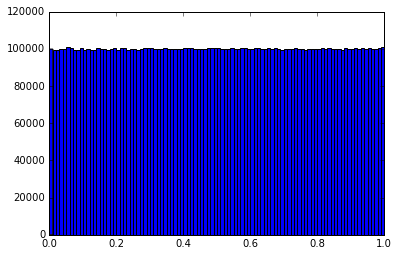

In [9]:
plt.hist(prns, bins = 100)
plt.show()

Let's do a KS test for the difference between consecutive PRNs.  If, under the null, they are IID uniform(0,1), then the differences between consecutive values should be IID triangular with distribution

$$\mathbb{P}(U_1 - U_2 \leq y) = -\frac{sign(y)}{2}y^2 + y + \frac{1}{2}$$

In [10]:
first_differences = prns[1:] - prns[:len(prns)-1]
kstest(first_differences, lambda x: triang.cdf(x, c = 0.5, loc = -1, scale = 2))

KstestResult(statistic=0.00022022401190403829, pvalue=0.7172039453555028)

# Serial tests

We'll use a chi-squared test to count how often pairs of integers occur.

In [11]:
ss = 100 # seed value
prng = SHA256(ss)

bin_counts = [str(np.floor(prng.random()*100)) + "," + str(np.floor(prng.random()*100)) for i in range(int(10**7/2))]

In [12]:
print(bin_counts[:5])
bin_counts = itemfreq(bin_counts)
chisquare(bin_counts[:,1].astype('int'))

['20.0,90.0', '93.0,43.0', '84.0,74.0', '76.0,62.0', '67.0,3.0']


Power_divergenceResult(statistic=10152.828, pvalue=0.13852676704983599)

# Gap test

For values $\alpha < \beta$, we say that a gap of length $r$ occurs when $U_j$ and $U_{j+r-1}$ lie in the interval $(\alpha,\beta)$ but $U_{j+1}, \dots, U_{j + r - 2}$ do not. We want to count the number of gaps of size $0$, $1,$ up to size $t$ for some reasonable value.

This is slightly different from Knuth's version.  He proposes generating random numbers until $n$ gaps are observed.  Instead, I will fix the sequence length and count how many gaps occur.  Then I'll condition on that number of gaps (same as the number of items in the range $(\alpha, \beta)$) to generate expected counts for each gap length.

In [13]:
def gap_test(sequence, alpha, beta, t):
    '''
    inputs:
    sequence = sequence of numbers between 0 and 1
    alpha    = lower limit of interval
    beta     = upper limit of interval
    t        = max gap size (anything with gap larger than t will fall in the last category)
    '''
    # check
    assert alpha >= 0
    assert beta <= 1
    assert alpha < beta
    
    # initialize
    count = [0 for r in range(t+1)]
    r = 0
    n = len(sequence)
    
    # count gaps of size 0, 1, ..., >=t
    for j in range(n):
        if sequence[j] >= alpha and sequence[j] < beta:
            if r >= t:
                count[t] += 1
            else:
                count[r] += 1
            r = 0
        else:
            r += 1
            
    # conduct chi-square test
    p = beta-alpha
    conditional_n = sum(count)
    expected = [conditional_n*p*(1-p)**power for power in range(t)]
    expected.append(conditional_n*(1-p)**t)
    return {'observed' :  count,
            'expected' : expected,
            'p-value' : chisquare(count, expected)[1]}

In [14]:
#gap_test(prns, 0.25, 0.75, 5)

# Coupon collector's test

This test analyzes the number $r$ of items in the sequence $Y_j, Y_{j+1}, \dots, Y_{j+r}$ (where $Y_j = \lfloor d U_j \rfloor$) to obtain all each of the integers $\{0, 1, \dots, d-1\}$ at least once.

In [15]:
def coupontest(sequence, d, t):
    '''
    Given a sequence of U(0,1) values, converts to integer values on {0, 1, ..., d-1}
    and tests the length of 'runs' needed to hit each integer at least once.
    The max run length considered is t.
    '''

    assert t >= d
    
    # convert to integer PRNs
    sequence = [int(np.floor(d*val)) for val in sequence]
    
    # initialize
    count = [0 for i in range(t+1)]
    occurs = [0 for k in range(d)]
    q = 0
    r = 0
    n = len(sequence)
    
    for j in range(n):
        r += 1
        if occurs[sequence[j]] == 0:
            occurs[sequence[j]] = 1
            q += 1
            if q == d:
                if r >= t:
                    count[t] += 1
                else:
                    count[r] += 1
                q = 0
                r = 0
                occurs = [0 for k in range(d)]
        j += 1
        
    expected = [0 for i in range(t+1)]
    conditional_n = sum(count)
    expected[d:t] = [conditional_n*comb(r-1, d-1)*math.factorial(d)/d**r for r in range(d, t)]
    expected[t] = conditional_n - sum(expected)
    return {'observed' :  count,
            'expected' : expected,
            'p-value' : chisquare(count, expected)[1]}    



#coupontest(prns, d=5, t=10) 
    

# Permutation test

This test looks at orderings of $t$-tuples $(U_{jt}, U_{jt + 1}, \dots, U_{jt + t - 1})$ for $0 \leq j < t$. In each tuple, there are $t!$ possible orderings.

In [16]:
def conductPermTest(sequence, tuplelen):
    '''
    Break sequence into tuples of length tuplelen. Find the ordering of each tuple, and do a chi-squared test.
    Under the null, each ordering has equal probability.
    '''
    
    nperms = np.floor(len(sequence)/tuplelen)
    counts = dict()
    
    for j in range(int(nperms)):
        f = str(np.argsort(sequence[(j*tuplelen):(j*tuplelen + tuplelen )]))
        if f in counts.keys():
            counts[f] += 1
        else:
            counts[f] = 1
    return chisquare(list(counts.values()))[1]

#conductPermTest(prns[:10**5], 3)

In [17]:
#conductPermTest(prns[:10**5], 5)

# Sample-by-index test

This is a test that I've devised based on the sample_by_index method. The method is used to generate a SRS of size k from n.  Briefly, it works by sampling an integer from $\{1, ..., n'\}$ for $n' = n, n-1, ... n-k+1$.  These draws should be independent and we'd hope to get every possible combination with equal frequency.  The probabilities are $\frac{(n-k)!}{n!}$.

Note in the code below, we work with $\{0, ..., n' - 1\}$ for convenience.

In [18]:
def conduct_sample_by_index_test(sequence, n, k):
    nprime = n
    j = 0
    samp = []
    counts = dict()
    
    for j in range(len(sequence)):
        if nprime > n-k:
            samp.append( np.floor(nprime * sequence[j]) )
            nprime -= 1
        else:
            f = str(samp)
            if f in counts.keys():
                counts[f] += 1
            else:
                counts[f] = 1
            nprime = n
            samp = []

    return {'counts' : counts,
            'p-value' : chisquare(list(counts.values()))[1]}

           
#conduct_sample_by_index_test(prns[:10**6], n=10, k=3)

# Compare seeds and sequence lengths

In [19]:
seedvalues = [100, 233424280, 429496729]
reps = np.linspace(10**4, 10**6, num = 10)
maxreps = reps[-1]

# initialize
seed_tracker = []
reps_count = []
chisq_pvalue = []
range_pvalue = []
ks_pvalue = []
ks_diff_pvalue = []
#serial_pvalue = []
gaps_pvalue = []
# coupon_pvalue = [] # this one isn't running quite right
permutation_pvalue = []
samplebyindex_pvalue = []

for ss in seedvalues:
    prng = SHA256(ss)
    sequence = prng.random(maxreps)
    first_differences = sequence[1:] - sequence[:len(sequence)-1]
    
    for rr in reps:
        print(ss, rr)
        seed_tracker.append(ss)
        reps_count.append(rr)
        chisq_pvalue.append(conductChisqTest(sequence[:rr]))
        range_pvalue.append(conductRangeTest(sequence[:rr]))
        ks_pvalue.append(kstest(sequence[:rr], 'uniform')[1])
        ks_diff_pvalue.append(kstest(first_differences[:rr], lambda x: triang.cdf(x, c = 0.5, loc = -1, scale = 2))[1])
#        serial_pvalue.append() # todo
        gaps_pvalue.append(gap_test(sequence[:rr], 0.25, 0.75, 5)['p-value'])
        samplebyindex_pvalue.append(conduct_sample_by_index_test(sequence[:rr], n=13, k=3)['p-value'])

res = pd.DataFrame({'seed' : seed_tracker,
                    'reps' :  reps_count,
                    'chisq' : chisq_pvalue,
                    'range' : range_pvalue,
                    'ks' : ks_pvalue,
                    'ks_diffs' : ks_diff_pvalue,
                    'gaps' : gaps_pvalue,
                    'samplebyindex' : samplebyindex_pvalue})
res.head()


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipyke

100 10000.0
100 120000.0
100 230000.0
100 340000.0
100 450000.0
100 560000.0
100 670000.0
100 780000.0
100 890000.0
100 1000000.0
233424280 10000.0
233424280 120000.0
233424280 230000.0
233424280 340000.0
233424280 450000.0
233424280 560000.0
233424280 670000.0
233424280 780000.0
233424280 890000.0
233424280 1000000.0
429496729 10000.0
429496729 120000.0
429496729 230000.0
429496729 340000.0
429496729 450000.0
429496729 560000.0
429496729 670000.0
429496729 780000.0
429496729 890000.0
429496729 1000000.0


,chisq,gaps,ks,ks_diffs,range,reps,samplebyindex,seed
0,0.294843,0.963595,0.629757,0.748042,0.796931,10000.0,1.000000,100
1,0.288279,0.547274,0.997321,0.593732,0.111401,120000.0,0.114629,100
2,0.453282,0.489603,0.923794,0.601276,0.482670,230000.0,0.372070,100
3,0.135481,0.275038,0.800999,0.524260,0.707068,340000.0,0.085036,100
4,0.439809,0.131033,0.969593,0.604619,0.146669,450000.0,0.016665,100


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


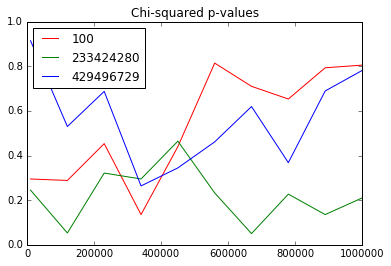

In [21]:
plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])

plt.plot(res.reps[res.seed == seedvalues[0]], res.chisq[res.seed == seedvalues[0]])
plt.plot(res.reps[res.seed == seedvalues[1]], res.chisq[res.seed == seedvalues[1]])
plt.plot(res.reps[res.seed == seedvalues[2]], res.chisq[res.seed == seedvalues[2]])
#plt.plot(res.reps[res.seed == seedvalues[3]], res.chisq[res.seed == seedvalues[3]])

plt.legend(seedvalues, loc='upper left')
plt.title("Chi-squared p-values")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


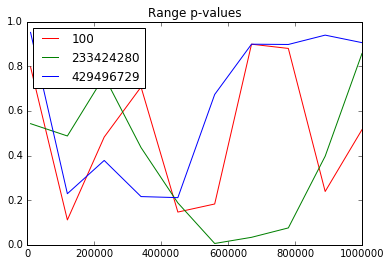

In [22]:
plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])


plt.plot(res.reps[res.seed == seedvalues[0]], res.range[res.seed == seedvalues[0]])
plt.plot(res.reps[res.seed == seedvalues[1]], res.range[res.seed == seedvalues[1]])
plt.plot(res.reps[res.seed == seedvalues[2]], res.range[res.seed == seedvalues[2]])
#plt.plot(res.reps[res.seed == seedvalues[3]], res.range[res.seed == seedvalues[3]])

plt.legend(seedvalues, loc='upper left')
plt.title("Range p-values")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


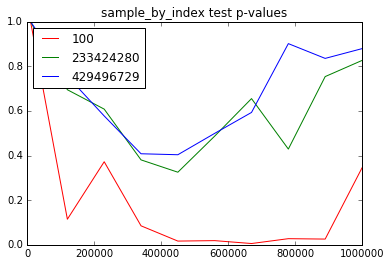

In [23]:
plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])


plt.plot(res.reps[res.seed == seedvalues[0]], res.samplebyindex[res.seed == seedvalues[0]])
plt.plot(res.reps[res.seed == seedvalues[1]], res.samplebyindex[res.seed == seedvalues[1]])
plt.plot(res.reps[res.seed == seedvalues[2]], res.samplebyindex[res.seed == seedvalues[2]])
#plt.plot(res.reps[res.seed == seedvalues[3]], res.samplebyindex[res.seed == seedvalues[3]])

plt.legend(seedvalues, loc='upper left')
plt.title("sample_by_index test p-values")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


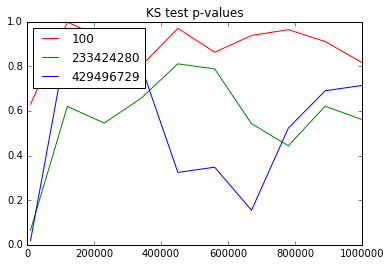

In [24]:
plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])


plt.plot(res.reps[res.seed == seedvalues[0]], res.ks[res.seed == seedvalues[0]])
plt.plot(res.reps[res.seed == seedvalues[1]], res.ks[res.seed == seedvalues[1]])
plt.plot(res.reps[res.seed == seedvalues[2]], res.ks[res.seed == seedvalues[2]])
#plt.plot(res.reps[res.seed == seedvalues[3]], res.ks[res.seed == seedvalues[3]])

plt.legend(seedvalues, loc='upper left')
plt.title("KS test p-values")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


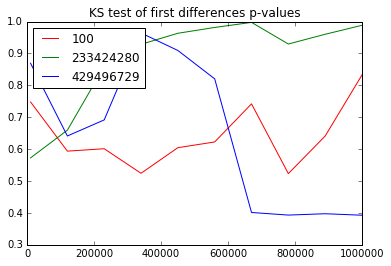

In [25]:
plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])


plt.plot(res.reps[res.seed == seedvalues[0]], res.ks_diffs[res.seed == seedvalues[0]])
plt.plot(res.reps[res.seed == seedvalues[1]], res.ks_diffs[res.seed == seedvalues[1]])
plt.plot(res.reps[res.seed == seedvalues[2]], res.ks_diffs[res.seed == seedvalues[2]])
#plt.plot(res.reps[res.seed == seedvalues[3]], res.ks_diffs[res.seed == seedvalues[3]])

plt.legend(seedvalues, loc='upper left')
plt.title("KS test of first differences p-values")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


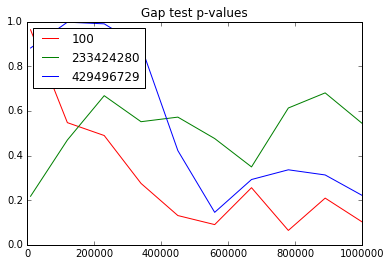

In [26]:
plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])


plt.plot(res.reps[res.seed == seedvalues[0]], res.gaps[res.seed == seedvalues[0]])
plt.plot(res.reps[res.seed == seedvalues[1]], res.gaps[res.seed == seedvalues[1]])
plt.plot(res.reps[res.seed == seedvalues[2]], res.gaps[res.seed == seedvalues[2]])
#plt.plot(res.reps[res.seed == seedvalues[3]], res.gaps[res.seed == seedvalues[3]])

plt.legend(seedvalues, loc='upper left')
plt.title("Gap test p-values")
plt.show()

In [35]:
colOrder = ['seed', 'reps', 'chisq', 'range', 'ks', 'ks_diffs', 'gaps', 'samplebyindex']
res[res.reps == 10**4][colOrder]

,seed,reps,chisq,range,ks,ks_diffs,gaps,samplebyindex
0,100,10000.0,0.294843,0.796931,0.629757,0.748042,0.963595,1.0
10,233424280,10000.0,0.244928,0.542738,0.065846,0.572517,0.217371,1.0
20,429496729,10000.0,0.914360,0.951645,0.019104,0.869467,0.881612,1.0


In [36]:
res[res.reps == 5.6*10**5][colOrder]

,seed,reps,chisq,range,ks,ks_diffs,gaps,samplebyindex
5,100,560000.0,0.814126,0.182826,0.862905,0.622523,0.090499,0.018675
15,233424280,560000.0,0.232481,0.005940,0.788071,0.981630,0.476079,0.486933
25,429496729,560000.0,0.461084,0.673531,0.347606,0.820467,0.145427,0.499286


In [37]:
res[res.reps == 10**6][colOrder]

,seed,reps,chisq,range,ks,ks_diffs,gaps,samplebyindex
9,100,1000000.0,0.804916,0.515967,0.816254,0.832752,0.102904,0.344508
19,233424280,1000000.0,0.209715,0.857136,0.561070,0.988412,0.544490,0.825887
29,429496729,1000000.0,0.780622,0.905680,0.713914,0.392765,0.221638,0.878818
